# Imports

In [1]:
import os
import pickle

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm

# Seaborn
import seaborn as sns
import seaborn as sns

# Sci-kit learn
from sklearn.datasets import load_files
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

# Keras
from keras.utils import np_utils
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical
from keras.preprocessing import image

from PIL import ImageFile                            

# Load the data

In [2]:
# Create path constants
DATA_DIR = r"state-farm-distracted-driver-detection/imgs"
TEST_DIR = os.path.join(DATA_DIR,"test")
TRAIN_DIR = os.path.join(DATA_DIR,"train")
MODEL_PATH = os.path.join(os.getcwd(),"basic_model")
PICKLE_DIR = os.path.join(os.getcwd(),"pickle_files")
CSV_DIR = os.path.join(os.getcwd(),"csv_files")

In [3]:
# Create the specified directories if it does not exist
if not os.path.exists(TEST_DIR):
    print("Testing data does not exists")
if not os.path.exists(TRAIN_DIR):
    print("Training data does not exists")
if not os.path.exists(MODEL_PATH):
    print("Model path does not exists")
    os.makedirs(MODEL_PATH)
    print("Model path created")
if not os.path.exists(PICKLE_DIR):
    os.makedirs(PICKLE_DIR)
if not os.path.exists(CSV_DIR):
    os.makedirs(CSV_DIR)

# Create data CSVs

In [4]:
def create_csv(DATA_DIR, filename):
    # Get the classes
    class_names = os.listdir(DATA_DIR)
    data = list()
    # Check if the class data folder is found if not we are in test directory
    if(os.path.isdir(os.path.join(DATA_DIR, class_names[0]))):
        # iterate through the classes
        for class_name in class_names:
            file_names = os.listdir(os.path.join(DATA_DIR, class_name))
            for file in file_names:
                data.append({
                    "filename": os.path.join(DATA_DIR,class_name,file),
                    "classname": class_name
                })
    else:
        class_name = "test"
        file_names = os.listdir(DATA_DIR)
        for file in file_names:
            data.append(({
                "filename": os.path.join(DATA_DIR,file),
                "classname": class_name
            }))
    data = pd.DataFrame(data)
    data.to_csv(os.path.join(os.getcwd(), "csv_files", filename), index=False)

In [5]:
# Create CSVs for train and test
create_csv(TRAIN_DIR,"train.csv")
create_csv(TEST_DIR,"test.csv")
# Load the train and test CSVs
data_train = pd.read_csv(os.path.join(os.getcwd(), "csv_files", "train.csv"))
data_test = pd.read_csv(os.path.join(os.getcwd(), "csv_files", "test.csv"))

# Data visualiztion

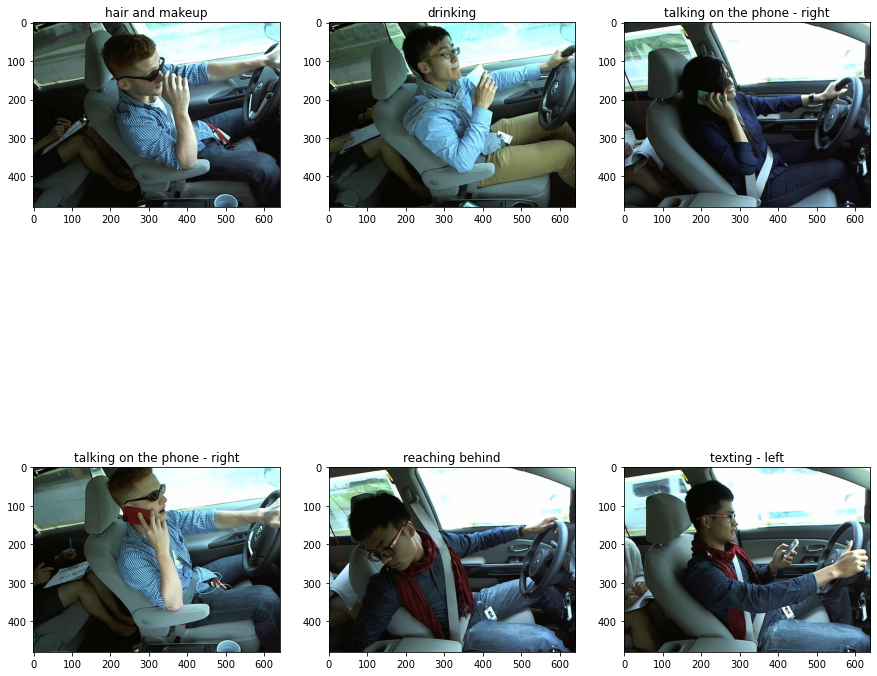

In [6]:
classes = {"c0": "safe driving",
           "c1": "texting - right",
           "c2": "talking on the phone - right",
           "c3": "texting - left",
           "c4": "talking on the phone - left",
           "c5": "operating the radio",
           "c6": "drinking",
           "c7": "reaching behind",
           "c8": "hair and makeup",
           "c9": "talking to passenger"
          }
# Take a random sample of the data
df = data_train.sample(frac=1).reset_index(drop=True)
plt.figure(figsize=(15, 15))
for i, row in df.iterrows():
    img_path = row.values[0]
    img = image.load_img(img_path)
    ax = plt.subplot(int(f"23{i+1}"))
    ax.margins(0.05)
    ax.imshow(img)
    label = row.values[1]
    label = classes[label]
    ax.set_title(label)
    if i > 4:
        break
plt.savefig(os.path.join(MODEL_PATH, "data_visualization_basic.png"))
plt.show()


## Data exploration

In [7]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22424 entries, 0 to 22423
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   filename   22424 non-null  object
 1   classname  22424 non-null  object
dtypes: object(2)
memory usage: 350.5+ KB


In [8]:
data_train['classname'].value_counts()

c0    2489
c3    2346
c4    2326
c6    2325
c2    2317
c5    2312
c1    2267
c9    2129
c7    2002
c8    1911
Name: classname, dtype: int64

In [9]:
data_train.describe()

,filename,classname
count,22424,22424
unique,22424,10
top,state-farm-distracted-driver-detection/imgs\tr...,c0
freq,1,2489


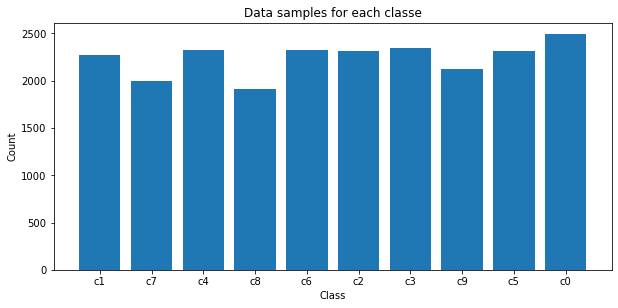

In [10]:
# Create a bar chart for the data samples for each class
nf = data_train['classname'].value_counts(sort=False)
labels = data_train['classname'].value_counts(sort=False).index.tolist()
y = np.array(nf)
x = range(len(y))
# Create figure
fig = plt.figure(figsize=(10, 10))
ay = fig.add_subplot(211)
plt.xticks(x, labels)
ay.bar(x, y)
plt.title('Data samples for each classe')
plt.xlabel('Class')
plt.ylabel('Count')
plt.savefig(os.path.join(MODEL_PATH, "data_samples_per_class.png"))
plt.show()

We can see that the training dataset is equally balanced to a great extent and hence we need not do any downsampling of the data.

In [11]:
data_test.head()

,filename,classname
0,state-farm-distracted-driver-detection/imgs\te...,test
1,state-farm-distracted-driver-detection/imgs\te...,test
2,state-farm-distracted-driver-detection/imgs\te...,test
3,state-farm-distracted-driver-detection/imgs\te...,test
4,state-farm-distracted-driver-detection/imgs\te...,test


In [12]:
print(f"There are total {data_train.shape[0]} training samples")
print(f"There are total {data_test.shape[0]} testing samples")

There are total 22424 training samples
There are total 79726 testing samples


# Data preprocessing

## Convert the labels to numerals

In [13]:
labels_list = list(set(data_train['classname'].values.tolist()))
labels_id = {label_name:id for id, label_name in enumerate(labels_list)}
print(f"labels_id = {labels_id}")
data_train['classname'].replace(labels_id, inplace=True)

labels_id = {'c7': 0, 'c4': 1, 'c0': 2, 'c3': 3, 'c8': 4, 'c1': 5, 'c2': 6, 'c5': 7, 'c6': 8, 'c9': 9}


In [14]:
# Save the labels list to the desk in a pickle file
with open(os.path.join(os.getcwd(),"pickle_files","labels_list.pkl"),"wb") as handle:
    pickle.dump(labels_id,handle)
# Categorize the labels
labels = to_categorical(data_train['classname'])
print(f"labels.shape = {labels.shape}")

labels.shape = (22424, 10)


## Splitting training data into train and test (validation) sets

In [15]:
# Split the data into 80% train and 20% test
x_train, x_test, y_train, y_test = train_test_split(data_train.iloc[:, 0], labels, test_size=0.2, random_state=7)

## Dcaling images
We scale the image to be 64 * 64 images instead of 640 * 480

In [16]:
# A function to load and resize the image
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(64, 64))
    # convert PIL.Image.Image type to 3D tensor with shape (64, 64, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 64,64, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

# A function to process all the images
def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [17]:
# Preprocess the data for Keras by normalizing the image to be between 0 and 1 with mean of 0.5 
train_tensors_path = os.path.join(os.getcwd(), "pickle_files", "train_tensors.pkl")
valid_tensors_path = os.path.join(os.getcwd(), "pickle_files", "valid_tensors.pkl")

# Save the labels list to the desk in a pickle file
if os.path.isfile(train_tensors_path):
    with open(train_tensors_path, 'rb') as f:
        train_tensors = pickle.load(f)
else:
    train_tensors = paths_to_tensor(x_train).astype('float32')/255 - 0.5
    with open(train_tensors_path, 'wb') as handle:
        pickle.dump(train_tensors, handle)
        
if os.path.isfile(valid_tensors_path):
    with open(valid_tensors_path, 'rb') as f:
        valid_tensors = pickle.load(f)
else:
    valid_tensors = paths_to_tensor(x_test).astype('float32')/255 - 0.5
    with open(valid_tensors_path, 'wb') as handle:
        pickle.dump(valid_tensors, handle)


# Building the Model

In [18]:
input_shape = (64, 64, 3)
kernel_initializer = 'glorot_normal'
padding = 'same'
activation = 'relu'

model = Sequential()

model.add(Conv2D(filters=64, kernel_size=2, padding=padding, activation=activation, 
                 input_shape=input_shape, kernel_initializer=kernel_initializer))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=128, kernel_size=2, padding=padding, activation=activation, 
                 kernel_initializer=kernel_initializer))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=256, kernel_size=2, padding=padding, activation=activation, 
                 kernel_initializer=kernel_initializer))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=512, kernel_size=2, padding=padding, activation=activation, 
                 kernel_initializer=kernel_initializer))
model.add(MaxPooling2D(pool_size=2))

model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(500, activation=activation, kernel_initializer=kernel_initializer))
model.add(Dropout(0.5))

model.add(Dense(10, activation='softmax', kernel_initializer=kernel_initializer))


model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 64)        832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 128)       32896     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 256)       131328    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 512)         5

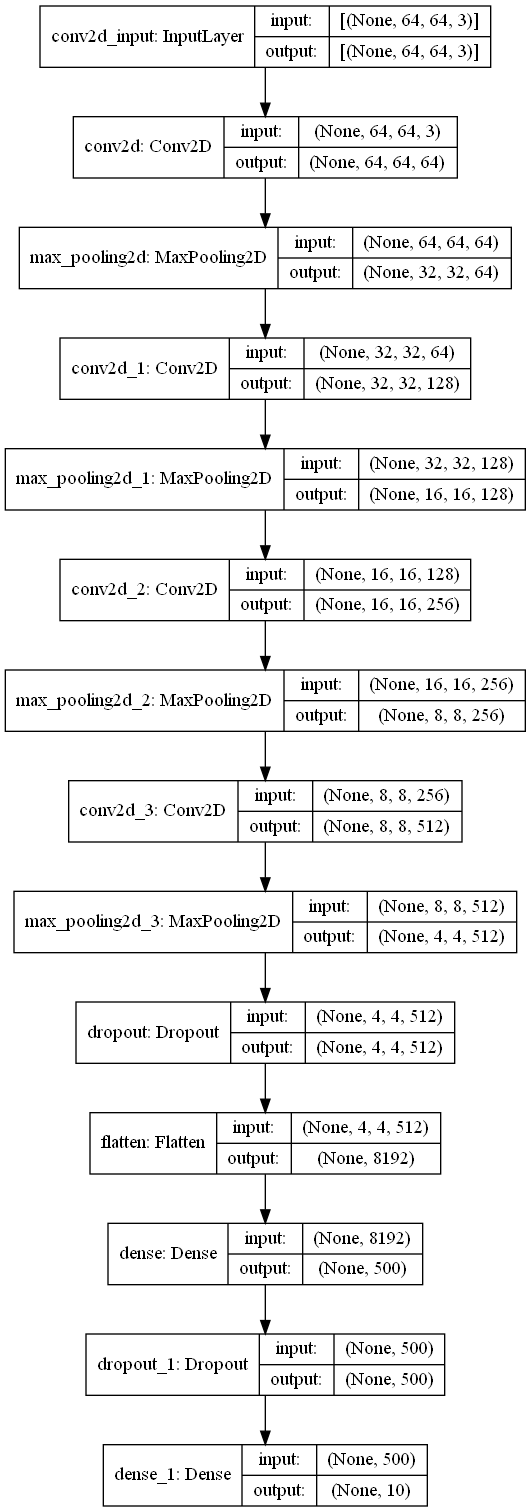

In [19]:
# Plot the model
plot_model(model, to_file=os.path.join(MODEL_PATH, "distraction_basic_model.png"), show_shapes=True, show_layer_names=True)

In [20]:
# Compile the model
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
epochs = 5
batch_size = 32
# Save the model with the best accuracy during the training process
filepath = os.path.join(MODEL_PATH, "distraction-{epoch:02d}-{val_accuracy:.2f}.hdf5")
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max', period=1)
callbacks_list = [checkpoint]
# Start the training process
model_history = model.fit(train_tensors, y_train, validation_data=(valid_tensors, y_test), 
                          epochs=epochs, batch_size=batch_size, shuffle=True, callbacks=callbacks_list)

Epoch 1/5
561/561 [==============================] - 101s 178ms/step - loss: 1.5078 - accuracy: 0.4456 - val_loss: 0.2189 - val_accuracy: 0.9269

Epoch 00001: val_accuracy improved from -inf to 0.92687, saving model to C:\Users\asebaq\distraction-detection\basic_model\distraction-01-0.93.hdf5
Epoch 2/5
561/561 [==============================] - 99s 176ms/step - loss: 0.2369 - accuracy: 0.9267 - val_loss: 0.0915 - val_accuracy: 0.9744

Epoch 00002: val_accuracy improved from 0.92687 to 0.97436, saving model to C:\Users\asebaq\distraction-detection\basic_model\distraction-02-0.97.hdf5
Epoch 3/5
561/561 [==============================] - 97s 173ms/step - loss: 0.1144 - accuracy: 0.9669 - val_loss: 0.0432 - val_accuracy: 0.9880

Epoch 00003: val_accuracy improved from 0.97436 to 0.98796, saving model to C:\Users\asebaq\distraction-detection\basic_model\distraction-03-0.99.hdf5
Epoch 4/5
561/561 [==============================] - 97s 173ms/step - loss: 0.0906 - accuracy: 0.9741 - val_loss: 

# Plot performance graphs

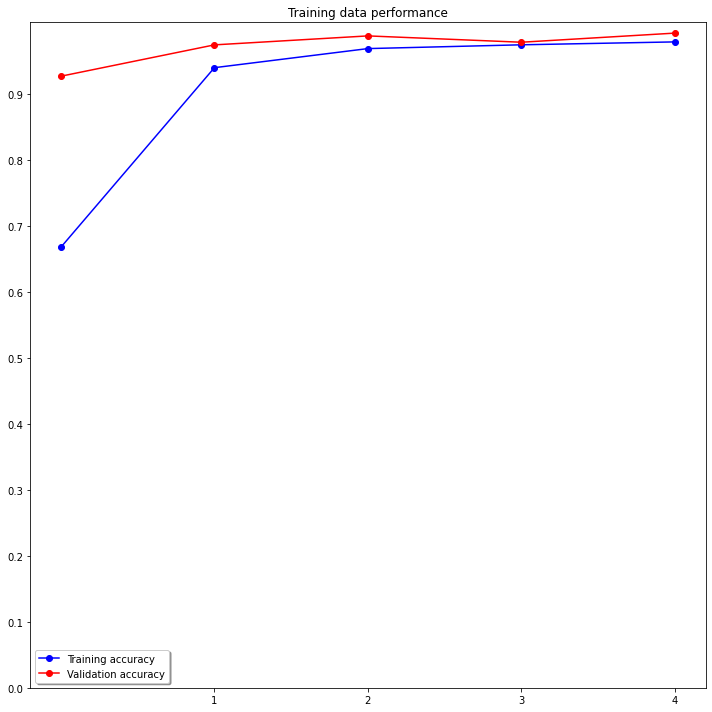

In [22]:
# Training date
fig = plt.figure(figsize=(10, 10))
plt.plot(model_history.history['accuracy'], '-bo', label="Training accuracy")
plt.plot(model_history.history['val_accuracy'], '-ro',label="Validation accuracy")
plt.xticks(np.arange(1, epochs, 1))
plt.yticks(np.arange(0, 1, 0.1))
legend = plt.legend(loc='best', shadow=True)
plt.title("Training data performance")
plt.tight_layout()
plt.savefig(os.path.join(MODEL_PATH, "basic_model_training.png"))
plt.show()


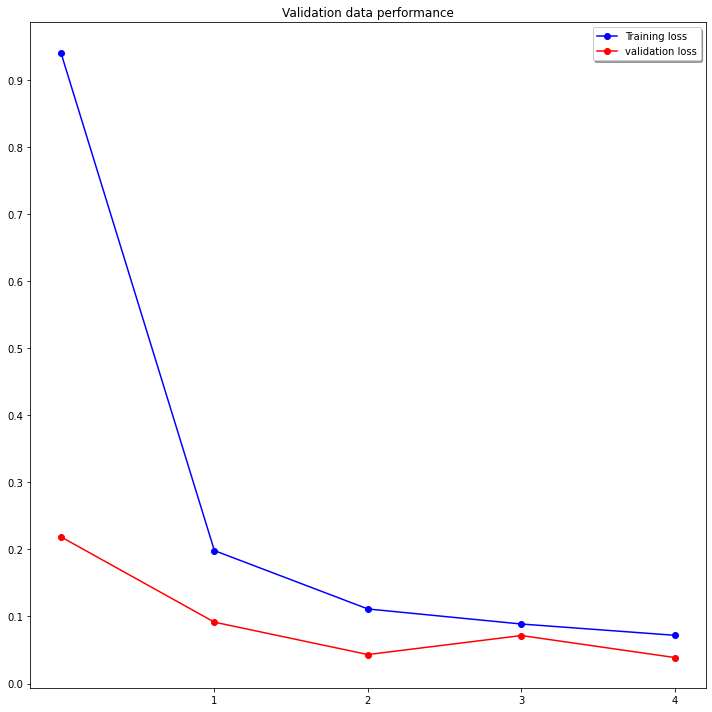

In [23]:
# Validation date
fig = plt.figure(figsize=(10, 10))
plt.plot(model_history.history['loss'], '-bo', label="Training loss")
plt.plot(model_history.history['val_loss'], '-ro', label="validation loss")
plt.xticks(np.arange(1, epochs, 1))
plt.yticks(np.arange(0, 1, 0.1))
legend = plt.legend(loc='best', shadow=True)
plt.title("Validation data performance")
plt.tight_layout()
plt.savefig(os.path.join(MODEL_PATH, "basic_model_validation.png"))
plt.show()

# Model Analysis
Finding the Confusion matrix, Precision, Recall and F1 score to analyse the model performance 

In [24]:
def show_confusion_matrix(confusion_matrix, class_names):
    figsize = (10,10)
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)
    fig = plt.figure(figsize=figsize)
    
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    fig.savefig(os.path.join(MODEL_PATH, "basic_model_confusion_matrix.png"))
    return fig

def show_heatmap(n_labels, n_predictions, class_names):
    labels = n_labels
    predictions = n_predictions
    matrix = confusion_matrix(labels.argmax(axis=1), predictions.argmax(axis=1))
    row_sum = np.sum(matrix, axis=1)
    w, h = matrix.shape
    c_m = np.zeros((w, h))
    for i in range(h):
        c_m[i] = matrix[i] * 100 / row_sum[i]
    c = c_m.astype(dtype = np.uint8)
    heatmap = show_confusion_matrix(c, class_names)

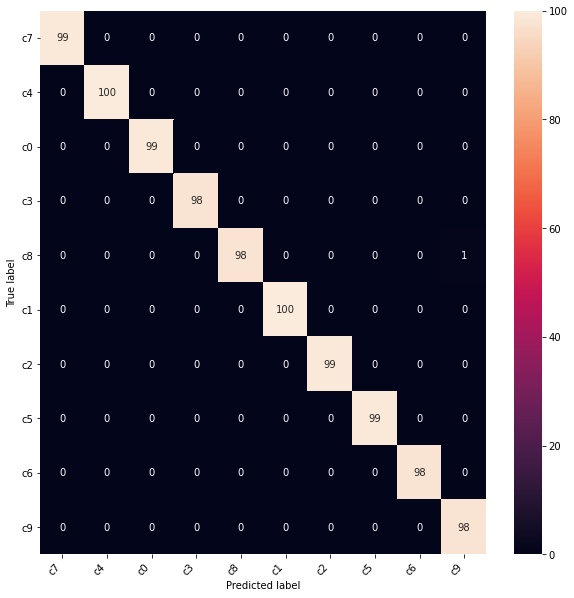

In [25]:
class_names = list()
for name, idx in labels_id.items():
    class_names.append(name)

y_pred = model.predict(valid_tensors)
show_heatmap(y_test, y_pred, class_names)

# Precision, recall, and F1 score

In [26]:
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {round(accuracy, 3)}")

# precision = tp / (tp + fp)
precision = precision_score(y_test, y_pred, average='weighted')
print(f"Precision: {round(precision, 3)}")

# recall = tp / (tp + fn)
recall = recall_score(y_test, y_pred, average='weighted')
print(f"Recall: {round(recall, 3)}")

# f1 = 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1 score: {round(f1, 3)}")

Accuracy: 0.992
Precision: 0.992
Recall: 0.992
F1 score: 0.992


# Test model on test data (Unlabeled data)
Actually this is do good to be true so let's see how the model perform on the unlabeled data

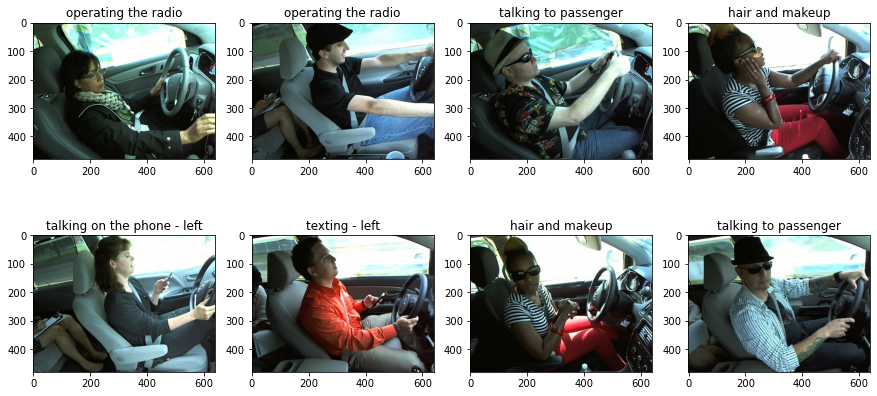

In [27]:
classes = {"c0": "safe driving",
           "c1": "texting - right",
           "c2": "talking on the phone - right",
           "c3": "texting - left",
           "c4": "talking on the phone - left",
           "c5": "operating the radio",
           "c6": "drinking",
           "c7": "reaching behind",
           "c8": "hair and makeup",
           "c9": "talking to passenger"
          }

plt.figure(figsize=(15, 15))
for i, img_path in data_test.iterrows():
    img_path = img_path.values[0]
    img = image.load_img(img_path)
    ax = plt.subplot(int(f"44{i+1}"))
    ax.margins(0.05)
    ax.imshow(img)
    img_tensor = path_to_tensor(img_path).astype('float32')/255 - 0.5
    label = np.argmax(model.predict(img_tensor))
    label = classes[labels_list[label]]
    ax.set_title(label)
    if i > 6:
        break
plt.savefig(os.path.join(MODEL_PATH, "basic_model_test_samples.png"))
plt.show()


# I think we have a serious problem which require data investigation
# ...
# After careful investigation we found that we have a data leakage problem


# Re-define the model

In [28]:
input_shape = (64, 64, 3)
kernel_initializer = 'glorot_normal'
padding = 'same'
activation = 'relu'

model = Sequential()

model.add(Conv2D(filters=64, kernel_size=2, padding=padding, activation=activation, 
                 input_shape=input_shape, kernel_initializer=kernel_initializer))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=128, kernel_size=2, padding=padding, activation=activation, 
                 kernel_initializer=kernel_initializer))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=256, kernel_size=2, padding=padding, activation=activation, 
                 kernel_initializer=kernel_initializer))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=512, kernel_size=2, padding=padding, activation=activation, 
                 kernel_initializer=kernel_initializer))
model.add(MaxPooling2D(pool_size=2))

model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(500, activation=activation, kernel_initializer=kernel_initializer))
model.add(Dropout(0.5))

model.add(Dense(10, activation='softmax', kernel_initializer=kernel_initializer))


model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 64, 64, 64)        832       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 128)       32896     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 256)       131328    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 8, 512)        

# Perform stratified sampling

In [29]:
# Create path constants
DATA_DIR = "state-farm-distracted-driver-detection\\imgs\\train\\"
images_df = pd.read_csv("state-farm-distracted-driver-detection\\driver_imgs_list.csv")
images_df.head()

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


In [30]:
# Add the full path to the image name
for i, row in images_df.iterrows():
    row["img"] = DATA_DIR + row["classname"] + "\\" + row["img"]
    
# Count the number of sample in each class
images_df["subject"].value_counts()

p021    1237
p022    1233
p024    1226
p026    1196
p016    1078
p066    1034
p049    1011
p051     920
p014     876
p015     875
p035     848
p047     835
p012     823
p081     823
p064     820
p075     814
p061     809
p056     794
p050     790
p052     740
p002     725
p045     724
p039     651
p041     605
p042     591
p072     346
Name: subject, dtype: int64

In [31]:
labels_list = list(set(images_df["classname"].values.tolist()))
labels_id = {label_name:id for id, label_name in enumerate(labels_list)}
print(f"labels_id = {labels_id}")
images_df["classname"].replace(labels_id, inplace=True)
labels = to_categorical(images_df["classname"])
print(f"labels.shape = {labels.shape}")

labels_id = {'c7': 0, 'c4': 1, 'c0': 2, 'c3': 3, 'c8': 4, 'c1': 5, 'c2': 6, 'c5': 7, 'c6': 8, 'c9': 9}
labels.shape = (22424, 10)


In [32]:
# A function to load and resize the image
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(64, 64))
    # convert PIL.Image.Image type to 3D tensor with shape (64, 64, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 64,64, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

# A function to process all the images
def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)



In [33]:
# Split the data into 80% train and 20% test (stratified)
test_df = images_df.loc[(images_df["subject"] == "p021") | (images_df["subject"] == "p022") | \
                        (images_df["subject"] == "p024") | (images_df["subject"] == "p026")]


mask = images_df["img"].isin(test_df["img"])
train_df = images_df.drop(images_df[mask].index)

print(f"images_df.shape = {images_df.shape}")
print(f"train_df.shape = {train_df.shape}")
print(f"test_df.shape = {test_df.shape}")

images_df.shape = (22424, 3)
train_df.shape = (17532, 3)
test_df.shape = (4892, 3)


In [34]:
x_train = list(train_df["img"])
y_train = to_categorical(train_df["classname"])

x_test = list(test_df["img"])
y_test = to_categorical(test_df["classname"])

In [35]:
train_tensors = paths_to_tensor(x_train).astype('float32')/255
valid_tensors = paths_to_tensor(x_test).astype('float32')/255

100%|█████████████████████████████████████████████████████████████████████████████| 4892/4892 [00:18<00:00, 262.38it/s]


# Re-train the model

In [36]:
# Compile the model
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

epochs = 10
batch_size = 32
# Save the model with the best accuracy during the training process
filepath = os.path.join(MODEL_PATH, "distraction-{epoch:02d}-{val_accuracy:.2f}.hdf5")
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max', period=1)
callbacks_list = [checkpoint]
# Start the training process
model_history = model.fit(train_tensors, y_train, validation_data=(valid_tensors, y_test), 
                          epochs=epochs, batch_size=batch_size, shuffle=True, callbacks=callbacks_list)

Epoch 1/10
548/548 [==============================] - 88s 159ms/step - loss: 2.3008 - accuracy: 0.1111 - val_loss: 2.2754 - val_accuracy: 0.1192

Epoch 00001: val_accuracy improved from -inf to 0.11917, saving model to C:\Users\asebaq\distraction-detection\basic_model\distraction-01-0.12.hdf5
Epoch 2/10
548/548 [==============================] - 89s 162ms/step - loss: 2.2605 - accuracy: 0.1653 - val_loss: 2.0255 - val_accuracy: 0.2993

Epoch 00002: val_accuracy improved from 0.11917 to 0.29926, saving model to C:\Users\asebaq\distraction-detection\basic_model\distraction-02-0.30.hdf5
Epoch 3/10
548/548 [==============================] - 87s 158ms/step - loss: 1.9967 - accuracy: 0.2764 - val_loss: 1.6563 - val_accuracy: 0.2946

Epoch 00003: val_accuracy did not improve from 0.29926
Epoch 4/10
548/548 [==============================] - 91s 165ms/step - loss: 1.6174 - accuracy: 0.4051 - val_loss: 1.6224 - val_accuracy: 0.3812

Epoch 00004: val_accuracy improved from 0.29926 to 0.38123, sa

# Plot performance graphs

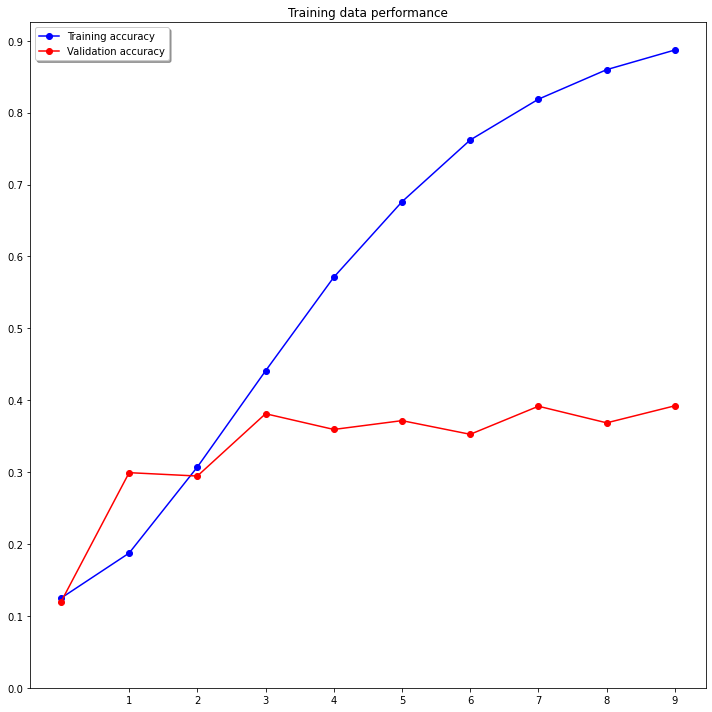

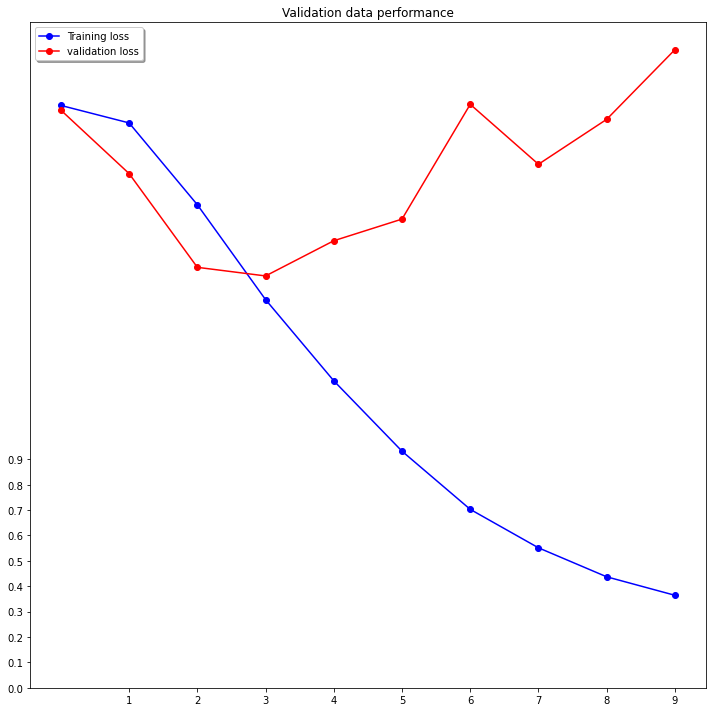

In [37]:
# Training date
fig = plt.figure(figsize=(10, 10))
plt.plot(model_history.history['accuracy'], '-bo', label="Training accuracy")
plt.plot(model_history.history['val_accuracy'], '-ro',label="Validation accuracy")
plt.xticks(np.arange(1, epochs, 1))
plt.yticks(np.arange(0, 1, 0.1))
legend = plt.legend(loc='best', shadow=True)
plt.title("Training data performance")
plt.tight_layout()
plt.savefig(os.path.join(MODEL_PATH, "basic_model_training.png"))
plt.show()

# Validation date
fig = plt.figure(figsize=(10, 10))
plt.plot(model_history.history['loss'], '-bo', label="Training loss")
plt.plot(model_history.history['val_loss'], '-ro', label="validation loss")
plt.xticks(np.arange(1, epochs, 1))
plt.yticks(np.arange(0, 1, 0.1))
legend = plt.legend(loc='best', shadow=True)
plt.title("Validation data performance")
plt.tight_layout()
plt.savefig(os.path.join(MODEL_PATH, "basic_model_validation.png"))
plt.show()

# Model analysis

Accuracy: 0.392
Precision: 0.427
Recall: 0.392
F1 score: 0.301


C:\Users\asebaq\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


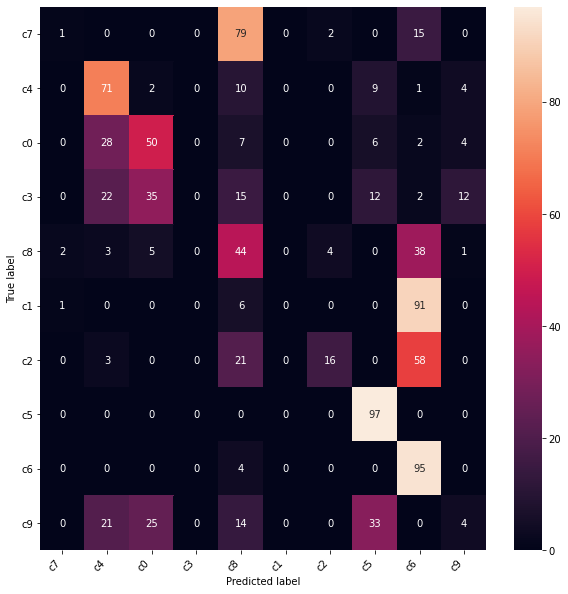

In [38]:
class_names = list()
for name, idx in labels_id.items():
    class_names.append(name)

y_pred = model.predict(valid_tensors)
show_heatmap(y_test, y_pred, class_names)

y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {round(accuracy, 3)}")

# precision = tp / (tp + fp)
precision = precision_score(y_test, y_pred, average='weighted')
print(f"Precision: {round(precision, 3)}")

# recall = tp / (tp + fn)
recall = recall_score(y_test, y_pred, average='weighted')
print(f"Recall: {round(recall, 3)}")

# f1 = 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1 score: {round(f1, 3)}")

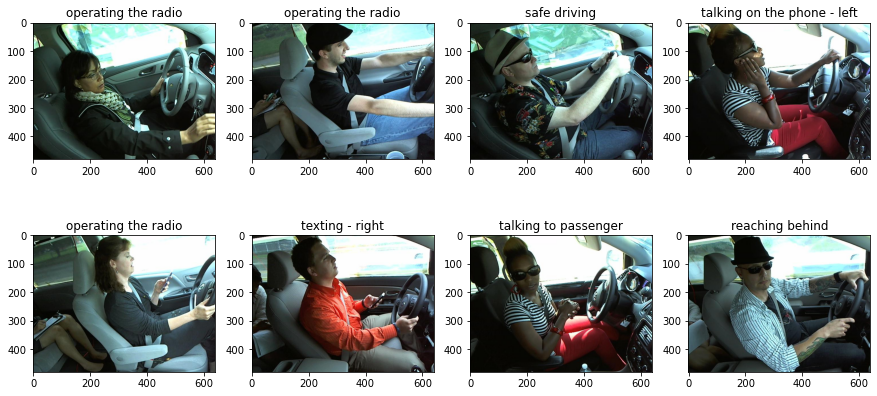

In [39]:
classes = {"c0": "safe driving",
           "c1": "texting - right",
           "c2": "talking on the phone - right",
           "c3": "texting - left",
           "c4": "talking on the phone - left",
           "c5": "operating the radio",
           "c6": "drinking",
           "c7": "reaching behind",
           "c8": "hair and makeup",
           "c9": "talking to passenger"
          }

plt.figure(figsize=(15, 15))
for i, img_path in data_test.iterrows():
    img_path = img_path.values[0]
    img = image.load_img(img_path)
    ax = plt.subplot(int(f"44{i+1}"))
    ax.margins(0.05)
    ax.imshow(img)
    img_tensor = path_to_tensor(img_path).astype('float32')/255 - 0.5
    label = np.argmax(model.predict(img_tensor))
    label = classes[labels_list[label]]
    ax.set_title(label)
    if i > 6:
        break
plt.savefig(os.path.join(MODEL_PATH, "basic_model_test_samples.png"))
plt.show()
